# Preliminary analysis

- Designers like to go to design talks and share knowledge. There must be some nearby companies that also do design.
- 30% of the company staff have at least 1 child.
- Developers like to be near successful tech startups that have raised at least 1 Million dollars.
- Executives like Starbucks A LOT. Ensure there's a starbucks not too far.
- Account managers need to travel a lot.
- Everyone in the company is between 25 and 40, give them some place to go party.
- The CEO is vegan.
- If you want to make the maintenance guy happy, a basketball stadium must be around 10 Km.
- The office dog—"Dobby" needs a hairdresser every month. Ensure there's one not too far away.

In [177]:
from Functions import *
from matplotlib import pyplot as plt
from folium import Choropleth, Circle, Marker, Icon, Map
from folium.plugins import HeatMap, MarkerCluster

In [2]:
companies = pd.read_csv("../data/companies_cleaned.csv")

In [61]:
# FUNCTION TO EXTRACT ALL SINGLE CATEGORIES
extract_categories(750)

In [16]:
# FUNCTION TO EXTRACT ALL STARBUCKS ONLY
extract_starbucks(750)

In [17]:
means, counts = calculate_distances("starbucks")

These are the csv files without your request:


'../data/11starbucks.csv'

In [18]:
means.insert(11, 0)

counts.insert(11, 0)


In [19]:
companies["Starbucks mean distance"] = means
companies["Starbucks counts"] = counts

In [20]:
companies

,Name,Number of employees,Description,Total money (in million $),Main address,City,Latitude,Longitude,Vegan restaurants mean distance,Vegan restaurants station counts,...,Tram station mean distance,Tram station counts,Basket courts mean distance,Basket courts counts,Pet grooming centers mean distance,Pet grooming centers counts,Airports mean distance,Airports counts,Starbucks mean distance,Starbucks counts
0,ngmoco,150,Games for the iPhone,44.8,185 Berry Street,San Francisco,37.770510,-122.401581,697.0,4,...,0.0,0,364.0,2,0.0,0,0.0,0,602.200000,5
1,Thumbplay,70,"Music, Videos, Games for Mobile Devices",41.5,599 Broadway,New York,40.725435,-73.997395,522.0,10,...,0.0,0,642.0,2,542.0,5,3852.0,1,484.428571,7
2,OMGPOP,50,Free online multiplayer game,16.6,SoHo,New York,40.723384,-74.001704,573.0,10,...,0.0,0,602.0,1,512.0,8,4193.0,1,550.700000,10
3,CyberArts,55,Gaming software developer,16.3,"51 Arbor St,",San Francisco,37.737609,-122.435399,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,746.000000,1
4,Zynga,115,Network of gaming applications,8.0,365 Vermont St.,San Francisco,37.765158,-122.404234,137.0,1,...,0.0,0,0.0,0,721.0,1,0.0,0,663.142857,7
5,Serious Business,22,Social Game Development Studio,4.0,580 Market Street,San Francisco,37.789321,-122.401362,392.0,5,...,613.0,3,0.0,0,306.0,1,0.0,0,489.600000,10
6,Exent,100,Games on Demand Leader,3.0,632 W. 28th St.,New York,40.752380,-74.005568,435.0,5,...,0.0,0,0.0,0,0.0,0,7571.0,2,563.600000,5
7,Exent,100,Games on Demand Leader,3.0,685 Market Street,San Francisco,37.787646,-122.402759,436.0,5,...,573.0,2,0.0,0,320.0,1,0.0,0,480.700000,10
8,GameLayers,5,Multiplayer Networked Games,2.0,1 Lombard Street,San Francisco,37.803847,-122.402468,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,120.000000,1
9,Shattered Reality Interactive,10,"Online Social Gaming, MMO",1.1,490 2nd Street,San Francisco,37.783046,-122.394067,458.0,2,...,0.0,0,0.0,0,530.0,5,0.0,0,652.000000,3


In [21]:
columns = ['Vegan restaurants mean distance', 'Daycare centers distance', 'Night clubs mean distance', 'Bus station mean distance'
          , 'Metro station mean distance','Train station mean distance', 'Tram station mean distance', 'Basket courts mean distance',
          'Pet grooming centers mean distance', 'Airports mean distance', 'Starbucks mean distance']

for i in columns:
    roundval(companies, i, 1)

In [23]:
companies.to_csv("../data/companies_final_dataset.csv", index = False)

## Principal Component Analysis

<img src="../images/ScoresLoadings.jpg" width="500">

<img src="../images/Hottelings.jpg" width="500">

<img src="../images/Variance.jpg" width="500">

In [228]:
companies_final = pd.read_csv("../data/companies_final_dataset.csv")

In [229]:
companies_final = companies_final.loc[(companies_final["Name"]=="ngmoco") | (companies_final["Name"]=="Zynga") | (companies_final["Name"]== "Serious Business") | (companies_final["Name"]== "Exent") | (companies_final["Name"]== "Shattered Reality Interactive")]

In [230]:
companies_final = companies_final.loc[(companies_final["City"]== "San Francisco")]

In [231]:
columns = ['Vegan restaurants mean distance', 'Daycare centers distance', 'Night clubs mean distance', 'Bus station mean distance'
          , 'Metro station mean distance','Train station mean distance', 'Tram station mean distance', 'Basket courts mean distance',
          'Pet grooming centers mean distance', 'Airports mean distance', 'Starbucks mean distance']

for i in columns:
    
    companies_final[f"{i.split(' ')[0]} score"] = companies_final[i]
    
    for j in companies_final[f"{i.split(' ')[0]} score"].values:

            if j in range(1,201):
                companies_final[f"{i.split(' ')[0]} score"] = companies_final[f"{i.split(' ')[0]} score"].replace(j,100)

            elif j in range(201,401):
                companies_final[f"{i.split(' ')[0]} score"] = companies_final[f"{i.split(' ')[0]} score"].replace(j,75)

            elif j in range(401,601):
                companies_final[f"{i.split(' ')[0]} score"] = companies_final[f"{i.split(' ')[0]} score"].replace(j,50)

            elif j in range(601,801):
                companies_final[f"{i.split(' ')[0]} score"] = companies_final[f"{i.split(' ')[0]} score"].replace(j,25)

            elif j > 800 or j == 0:
                companies_final[f"{i.split(' ')[0]} score"] = companies_final[f"{i.split(' ')[0]} score"].replace(j,0)

In [234]:
companies_final["Total score"] = [860.14, 1281.02, 1465.655, 1460.315, 219.175, 219.175]

In [235]:
companies_final.to_csv("../data/companies_definitive_dataset.csv", index = False)

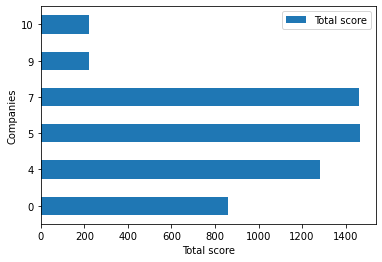

In [236]:
companies_final[["Name", "Total score"]].plot(kind="barh", xlabel = "Total score", ylabel = "Companies")
plt.show()